# Trying out an LSTM setup
## Using generated data
### Bi-directional LSTM with adversarial softmax layer

In [1]:
import numpy as np
import gym

def cart_pole(observation):
        
        position, velocity, angle, angle_velocity = observation
        action = int(3. * angle + angle_velocity > 0.)
        return action
        
def mountain_car(observation):

    position, velocity = observation
    lb = min(-0.09 * (position + 0.25) ** 2 + 0.03,
            0.3 * (position + 0.9) ** 4 - 0.008)
    ub = -0.07 * (position + 0.38) ** 2 + 0.07
    end = position > 0.2 and velocity > 0.02
    hard_end = position > 0.45
    begin = position < -0.45 and velocity < 0.001 and velocity > -0.001
    if begin or (lb < velocity < ub) or end or hard_end:
        action = 2 
    else:
        action = 0
    return action

class Expert(object):
        
    
    def __init__(self, env_name):
        
        policies = {
            'CartPole-v0': cart_pole,
            'MountainCar-v0': mountain_car
        }
        self.env_name = env_name
        self.env = gym.make(self.env_name)
        self.policy = policies[env_name]
        
    def generate_data(self, num_episodes=1):

        trajectories = []
        rewards = []
        splits = []
        counter = 0
        for i in range(num_episodes):


            observation = self.env.reset()
            done = False
            rd = 0
            
            while not done:

                action = self.policy(observation)
                trajectories.append(
                    [
                        feature for feature in observation
                    ] + [action] + [i]
                )
                observation, reward, done, _ = self.env.step(action)
                rd += reward
                counter += 1
            
            rewards.append(rd)
            splits.append(counter)
                
        return np.array(trajectories), np.mean(rewards), splits

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

### Generate data

In [3]:

expert = Expert('MountainCar-v0')
NUMBER_OF_EPISODES = 25
data, avg_reward, splits = expert.generate_data(NUMBER_OF_EPISODES)
avg_reward

-104.48

### Plot expert data

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

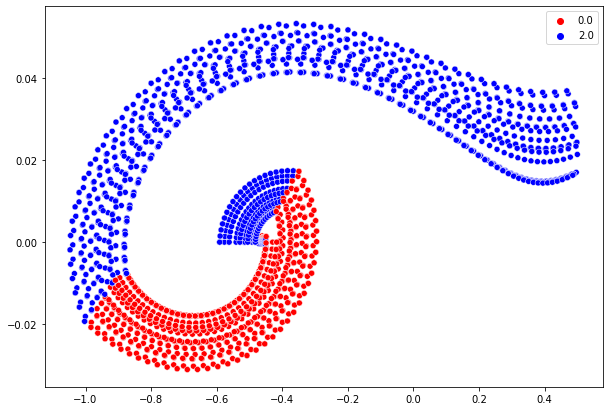

In [5]:
colors = np.array(['red', 'green', 'blue'])
palette = colors[np.unique(data[:,2]).astype(int)].tolist()

fig, ax = plt.subplots(figsize=(10, 7))
_ = sns.scatterplot(x=data[:,0], y=data[:,1], hue=data[:,2], palette=palette)

### Preprocess data into sequences

In [8]:
X_partitioned = np.split(data, splits)[0:NUMBER_OF_EPISODES]
max_len = np.max([len(x) for x in X_partitioned])
for i in range(len(X_partitioned)):

  for j in range(len(X_partitioned[i])):

    X_partitioned.append(X_partitioned[i][0:j])

X_partitioned_test = np.split(data, splits)[0:NUMBER_OF_EPISODES]
max_len

146

In [9]:
import torch
torch.cuda.CUDA_LAUNCH_BLOCKING=1
device = torch.device('cuda:0')

In [10]:
def seq_to_x(seq, pad_to):
    
    return [
            [seq[i][0], seq[i][1], int(i==0), 0] if i < len(seq)
            else [99, 99, 0, 1]
            for i in range(pad_to)
        ]

def seq_to_target(seq, pad_to):
    
    return [
            seq[i][2] if i < len(seq) else 1 for i in range(pad_to)
        ]


def training_X(data, max_len):
    
    return torch.tensor(
        np.array(
            [
                seq_to_x(seq, max_len) for seq in data
            ],
            dtype=np.float
        ),
        dtype=torch.float
    )

def training_Y(data, max_len):
    
    return torch.tensor(
        [
            seq_to_target(seq, max_len) for seq in data
        ],
        dtype=torch.long
    )

def true_indicies(Y):
    
    true = []
    for i in range(Y.shape[0]):
        
        if Y[i] == 0 or Y[i] == 2:
            true.append(i)
    
    return true

In [11]:
X = training_X(X_partitioned, max_len).to(device)
X_test = training_X(X_partitioned_test, max_len).to(device)

In [12]:
Y = torch.unsqueeze(training_Y(X_partitioned, max_len), dim=2).to(device)
Y_test = training_Y(X_partitioned_test, max_len)
true = true_indicies(Y_test.view(-1))
torch.unique(Y)

tensor([0, 1, 2], device='cuda:0')

In [13]:
torch.randn((5, 2, 6))[:,:,0:-1].shape

torch.Size([5, 2, 5])

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class PolicyCNN(nn.Module):
    
    def __init__(self, input_dim, conv_channels, target_size):
        
        super(PolicyCNN, self).__init__()
        
        self.conv = nn.Conv1d(
            input_dim,
            out_channels=conv_channels,
            kernel_size = 10,
            padding = 5,
            padding_mode = 'zeros',
            bias=True,
        )

        self.maxpool = nn.MaxPool1d(
              4,
              padding=2
        )

        
        self.linear = nn.Linear(conv_channels, target_size)
        
        self.output = nn.LogSoftmax(dim=2)
        
    def forward(self, batch):
        
        #print(batch.shape)
        batch = torch.einsum('b l i -> b i l', batch)
        conv_out = self.conv(batch)
        #print(conv_out.shape)
        #pool_out = self.maxpool(conv_out)
        pool_out = torch.einsum('b l i -> b i l', conv_out[:,:,0:-1])
        #print(pool_out.shape)
        linear_out = self.linear(pool_out)
        #print(linear_out.shape)
        out = self.output(linear_out)
        #print(out.shape)
        return out
    
    def predict(self, X):
        
        with torch.no_grad():
            pred = self.forward(X)
        
        return torch.argmax(pred, dim=2).view(-1)

model = PolicyCNN(4, 20, 3).to(device)

In [49]:
def train(xdata, ydata, model, n_epochs, lr=0.01, print_every=100):
    '''Train the neural model with the given training data'''

    criterion = torch.nn.NLLLoss()

    optimizer = torch.optim.SGD(model.parameters(), lr = 0.01) 


    for epoch in range(n_epochs):
        
        model.zero_grad()
        
        Y_pred = model(xdata)
        
        #print(Y_pred.view(-1, 2).shape, ydata.view(-1).shape)
        loss = criterion(Y_pred.view(-1, 3), ydata.view(-1))
        
        if epoch % print_every == 0: print('epoch: ', epoch,' loss: ', loss.item()) 
        if loss.item() < 0.10: lr=0.001
        if loss.item() < 0.075: lr=0.0005
        loss.backward()

        optimizer.step()
        
    return model

In [50]:
train(X, Y, model, 10000, lr=0.01, print_every=1000)

epoch:  0  loss:  0.6167063117027283
epoch:  1000  loss:  0.26569247245788574
epoch:  2000  loss:  0.2569199204444885
epoch:  3000  loss:  0.2536277174949646
epoch:  4000  loss:  0.2514987289905548
epoch:  5000  loss:  0.2510567307472229
epoch:  6000  loss:  0.25009286403656006
epoch:  7000  loss:  0.24913360178470612
epoch:  8000  loss:  0.2482239305973053
epoch:  9000  loss:  0.24734778702259064


PolicyCNN(
  (conv): Conv1d(4, 20, kernel_size=(10,), stride=(1,), padding=(5,))
  (maxpool): MaxPool1d(kernel_size=4, stride=4, padding=2, dilation=1, ceil_mode=False)
  (linear): Linear(in_features=20, out_features=3, bias=True)
  (output): LogSoftmax(dim=2)
)

In [51]:
preds = model.predict(X_test)[true].cpu()
preds

tensor([0, 0, 0,  ..., 0, 0, 0])

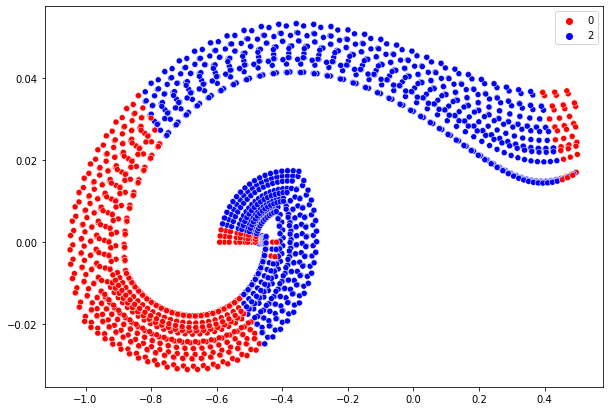

In [52]:
fig, ax = plt.subplots(figsize=(10,7))
_ = sns.scatterplot(x=data[:,0], y=data[:,1], hue=preds, palette=['red', 'blue'])

In [ ]:
env = gym.make('MountainCar-v0')
rewards = []


for i in range(1):

  # print(i)
  observation = env.reset()
  done = False
  rd = 0
  traj = torch.unsqueeze(torch.tensor([[observation[0], observation[1], 0, 1]], dtype=torch.float), dim=0).to(device)
  # print(observation)
  while not done:
  
    action = model.predict(traj)
    # print(action[-rd].item())
    observation, reward, done, _ = env.step(int(action[-rd].item()))
    rd += int(reward)
    traj = torch.cat(
        [
          traj,
          torch.unsqueeze(
              torch.tensor(
                    [[ob for ob in observation]+[0,0]],
                    dtype=torch.float
                  ).to(device),
                  dim=1
            )
        ]
    ).to(device)
    #print(traj)

  rewards.append(rd)

np.mean(rewards)